In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re


In [0]:
def Preprocess_text(data):
    data['Title'] = data['Title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Title'] = data['Title'].apply(lambda x: x.lower())
    data['Title'] = data['Title'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    data['Article'] = data['Article'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Article'] = data['Article'].apply(lambda x: x.lower())
    data['Article'] = data['Article'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    data['Author'] = data['Author'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r' ',x))
    data['Author'] = data['Author'].apply(lambda x: x.lower())
    data['Author'] = data['Author'].apply(lambda x: re.sub(r'[0-9]+',r' NUM ',x))
    return data

In [0]:
df = pd.read_csv('/content/drive/My Drive/Fake-News-Detection/dataset/Poltifact_dataset.csv',sep=',',index_col='idx')

df = Preprocess_text(df)

labelencoder = LabelEncoder()
#df['Image'] = labelencoder.inverse_transform(df['Image'])
df['Labels'] = labelencoder.fit_transform(df['Labels'])
print(labelencoder.classes_)
df.head()

['FALSE' 'Half-True' 'Mostly False' 'Mostly True' 'Pants on Fire!' 'TRUE']


,Title,Date,Author,Article,Labels
idx,,,,,
0,no bill cosby wasn t framed for sexual assaul...,"on Monday, November 4th, 2019 at 2:31 p.m.",samantha putterman,actor and comedian bill cosby was convicted...,4
1,green new deal doesn t mention abortion but n...,"on Friday, November 1st, 2019 at 1:39 p.m.",tom kertscher,attacks on the green new deal include claims...,2
2,subpoenas vs bills what this cnn pundit got ...,"on Monday, November 4th, 2019 at 2:03 p.m.",bill mccarthy,cnn commentator mike shields took aim at hou...,0
3,kamala harris didn t say democrats are coming...,"on Monday, November 4th, 2019 at 1:03 p.m.",daniel funke,a quote from sen kamala harris attacking su...,4
4,nancy pelosi overstates republican gains in im...,"on Monday, November 4th, 2019 at 11:44 a.m.",jon greenberg,house republicans voted unanimously against ...,2


In [0]:
train_all = df[['Author','Title','Article']]
target_all = df['Labels']
column = df['Title']
print(column[3])
train_all.head()

kamala harris didn t say democrats are  coming for  trump supporters in  NUM 


,Author,Title,Article
idx,,,
0,samantha putterman,no bill cosby wasn t framed for sexual assaul...,actor and comedian bill cosby was convicted...
1,tom kertscher,green new deal doesn t mention abortion but n...,attacks on the green new deal include claims...
2,bill mccarthy,subpoenas vs bills what this cnn pundit got ...,cnn commentator mike shields took aim at hou...
3,daniel funke,kamala harris didn t say democrats are coming...,a quote from sen kamala harris attacking su...
4,jon greenberg,nancy pelosi overstates republican gains in im...,house republicans voted unanimously against ...


In [0]:
%tensorflow_version 2.x
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


max_length = max([len(s.split()) for s in train_all['Article']])
max_length2 = max([len(s.split()) for s in train_all['Title']])
max_length3 = max([len(s.split()) for s in train_all['Author']])
x_train, x_test, y_train, y_test = train_test_split(train_all,target_all, test_size=0.2, random_state=42)
tokenizer = Tokenizer()
tokenizer2 = Tokenizer()
tokenizer3 = Tokenizer()
tokenizer.fit_on_texts(list(train_all['Article']))
x_train_Article_tokens = tokenizer.texts_to_sequences(list(x_train['Article']))
x_test_Article_tokens = tokenizer.texts_to_sequences(list(x_test['Article']))
x_train_Article_pad = pad_sequences(x_train_Article_tokens,maxlen=max_length,padding='post')
x_test_Article_pad = pad_sequences(x_test_Article_tokens,maxlen=max_length,padding='post')

unique_words = len(tokenizer.word_index)

tokenizer2.fit_on_texts(train_all['Title'])
x_train_Title_tokens = tokenizer2.texts_to_sequences(x_train['Title'])
x_test_Title_tokens = tokenizer2.texts_to_sequences(x_test['Title'])
x_train_Title_pad = pad_sequences(x_train_Title_tokens,maxlen=max_length2,padding='post')
x_test_Title_pad = pad_sequences(x_test_Title_tokens,maxlen=max_length2,padding='post')

unique_words = len(tokenizer.word_index)+1

tokenizer3.fit_on_texts(train_all['Author'])
x_train_Author_tokens = tokenizer3.texts_to_sequences(x_train['Author'])
x_test_Author_tokens = tokenizer3.texts_to_sequences(x_test['Author'])
x_train_Author_pad = pad_sequences(x_train_Author_tokens,maxlen=max_length3,padding='post')
x_test_Author_pad = pad_sequences(x_test_Author_tokens,maxlen=max_length3,padding='post')

unique_words = len(tokenizer.word_index)+1

print(x_train_Article_pad.shape)
print(x_train_Title_pad.shape)
print(x_train_Author_pad.shape)
print(x_test_Article_pad.shape)
print(x_test_Title_pad.shape)
print(x_test_Author_pad.shape)
print('Found %d unique words.' % len(tokenizer.word_index))
print('Found %d unique words.' % len(tokenizer2.word_index))
print('Found %d unique words.' % len(tokenizer3.word_index))

(13092, 6485)
(13092, 34)
(13092, 4)
(3273, 6485)
(3273, 34)
(3273, 4)
Found 72848 unique words.
Found 13579 unique words.
Found 752 unique words.


In [0]:
import os
import numpy as np
embeddings_index = {}
#GLOVE_DIR = 'glove.6B/'
f = open('/content/drive/My Drive/Fake-News-Detection/glove.6B.50d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
word_index = tokenizer.word_index
word_index2 = tokenizer2.word_index
word_index3 = tokenizer3.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix2 = np.zeros((len(word_index2) + 1, 50))
for word, i in word_index2.items():
    embedding_vector2 = embeddings_index.get(word)
    if embedding_vector2 is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix2[i] = embedding_vector2
embedding_matrix3 = np.zeros((len(word_index3) + 1, 50))
for word, i in word_index3.items():
    embedding_vector3 = embeddings_index.get(word)
    if embedding_vector3 is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix3[i] = embedding_vector3

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense,Conv1D, GlobalMaxPooling1D, Dropout, Embedding, BatchNormalization, Conv2D,Reshape,Activation,Concatenate, Input,LSTM,Bidirectional, GRU,MaxPool2D,Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# the dimension of vectors to be used

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 64
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 20
# # # # # # 
inputAr = Input(shape=max_length)
input_Article=Embedding(len(word_index)+1,50,weights=[embedding_matrix],input_length=[embedding_matrix],trainable=True,name='Article')(inputAr)
hidden2=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Article)
#################
 
# # # # # # # # # # # # # 
inputT = Input(shape=max_length2)
input_Title=Embedding(len(word_index2)+1,50,weights=[embedding_matrix2],input_length=[embedding_matrix2],trainable=True,name='Title')(inputT )
hidden2_2=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Title)

# # # # # # # # # # # # # 
inputAu = Input(shape=max_length3)
input_Author=Embedding(len(word_index3)+1,50,weights=[embedding_matrix3],input_length=[embedding_matrix3],trainable=True,name='Author')(inputAu  )
hidden2_3=Conv1D(filters,kernel_size,padding='valid',strides=1)(input_Author)
# # # # # # # # # # # # # 
maxpool_0 = GlobalMaxPooling1D()(hidden2)
maxpool_1 = GlobalMaxPooling1D()(hidden2_2)
maxpool_2 = GlobalMaxPooling1D()(hidden2_3)
# # # # # # # # # # # # # 

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
# # # # # # # # # # # # # 
dropout = Dropout(0.4)(concatenated_tensor)
dense = Dense(200,kernel_initializer='he_normal')(dropout)
batch_norm2 = BatchNormalization()(dense)
activation = Activation('relu')(batch_norm2)
dense2 = Dense(50,kernel_initializer='he_normal')(activation)
batch_norm3 = BatchNormalization()(dense2)
activation2 = Activation('relu')(batch_norm3)
dropout2 = Dropout(0.4)(activation2)
output = Dense(6, activation='softmax')(dropout2)
# # # # # # # # # # # # # 

# this creates a model that includes
model = keras.Model(inputs=[inputAr,inputT,inputAu], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6485)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
Article (Embedding)             (None, 6485, 50)     3642450     input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
import numpy as np
import time

y_train = np.array(y_train)
y_test = np.array(y_test)

start_time_bi_CNN = time.time()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit((x_train_Article_pad, x_train_Title_pad, x_train_Author_pad), y_train, epochs=20,validation_split=0.2,batch_size=64)

end_time_bi_CNN = time.time()

Train on 10473 samples, validate on 2619 samples
Epoch 1/20
10473/10473 [==============================] - 48s 5ms/sample - loss: 1.8954 - accuracy: 0.2381 - val_loss: 1.4161 - val_accuracy: 0.3608
Epoch 2/20
10473/10473 [==============================] - 45s 4ms/sample - loss: 1.1654 - accuracy: 0.5465 - val_loss: 0.5716 - val_accuracy: 0.8030
Epoch 3/20
10473/10473 [==============================] - 45s 4ms/sample - loss: 0.6361 - accuracy: 0.7749 - val_loss: 0.3133 - val_accuracy: 0.8809
Epoch 4/20
10473/10473 [==============================] - 45s 4ms/sample - loss: 0.3566 - accuracy: 0.8892 - val_loss: 0.1150 - val_accuracy: 0.9767
Epoch 5/20
10473/10473 [==============================] - 45s 4ms/sample - loss: 0.1714 - accuracy: 0.9588 - val_loss: 0.0631 - val_accuracy: 0.9855
Epoch 6/20
10473/10473 [==============================] - 45s 4ms/sample - loss: 0.1054 - accuracy: 0.9759 - val_loss: 0.0385 - val_accuracy: 0.9897
Epoch 7/20
10473/10473 [==============================] -

In [0]:
model.evaluate((x_test_Article_pad,x_test_Title_pad,x_test_Author_pad),y_test)

3273/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.04032453018225745, 0.9923617]

In [91]:
Author='Jeremy Herb'
Title='Democrats release impeachment report detailing overwhelming evidence of misconduct and obstruction'
Article="""House Democrats say evidence of President Donald Trump's misconduct and obstruction of Congress is "overwhelming," charging that Trump's conduct toward Ukraine compromised national security in a new report released Tuesday that will form the backbone of the impeachment proceedings against the President.

The 300-page report from the House Intelligence Committee sets the stage for the impeachment of a US president for just the third time in history. The report stops short of outright recommending impeachment, with House Intelligence Chairman Adam Schiff and the other committee chairs leading the inquiry said that was a decision Congress ultimately has to make.
But the report makes clear that's where Democrats are heading.
"I'm going to reserve any kind of a public judgment on that until I have a chance to consult with my colleagues, with our leadership," Schiff, a California Democrat, said when asked if there was evidence for impeachment. "As you can tell, I am gravely concerned that if we merely accept this that we invite not only further corruption of our elections by this President, but we also invite it of the next president."
The report release kicks off what's poised to be a frenzied month in the House, with Democrats on track to potentially vote on impeaching Trump by Christmas. The House Intelligence Committee will vote to approve the report Tuesday evening, and will then send it to the Judiciary Committee, which plans to hold hearings and would draft articles of impeachment against Trump.
The report is broken down into two sections, one on Ukraine and the other on obstruction of Congress — both of which are expected to be separate articles of impeachment.
Democrats alleged that the July 25 call between Trump and Ukrainian President Volodymyr Zelensky — in which Trump asked Zelensky to investigate former Vice President Joe Biden — was the "dramatic crescendo" of a months-long campaign driven by the President that involved a number of senior officials, including Vice President Mike Pence, Secretary of State Mike Pompeo and acting chief of staff Mick Mulvaney.
"The President engaged in this course of conduct for the benefit of his own presidential reelection, to harm the election prospects of a political rival, and to influence our nation's upcoming presidential election to his advantage," the report says. "In doing so, the President placed his own personal and political interests above the national interests of the United States, sought to undermine the integrity of the US presidential election process, and endangered US national security."
Democrats charged that the White House's obstruction of their impeachment investigation was an "unprecedented campaign," detailing the numerous subpoenas that were defied over the two-month investigation.
"Indeed, it would be hard to imagine a stronger or more complete case of obstruction than that demonstrated by the President since the inquiry began," the report says.
Schiff said that the report does not answer every question Democrats have investigated, in part, he argued, because of the White House stonewalling. But he argued there was a "grave risk to the country with waiting until we have every last fact, when we already know enough about the President's misconduct to make a responsible judgment about whether we think that's compatible with the office of the President."
The White House and congressional Republicans have rejected the Democratic allegations and dismissed the Democratic report on Tuesday. Congressional Republicans released their report ahead of the Democrats on Monday, a document that fully defended the President's actions on Ukraine and accused Democrats of rushing to impeach the President without any evidence that Trump did anything wrong.
"At the end of a one-sided sham process, Chairman Schiff and the Democrats utterly failed to produce any evidence of wrongdoing by President Trump," White House press secretary Stephanie Grisham said in a statement. "This report reflects nothing more than their frustrations. Chairman Schiff's report reads like the ramblings of a basement blogger straining to prove something when there is evidence of nothing."
Democrats subpoenaed phone records
The Democratic report is based largely on the 17 witness interviews that were conducted over a two-month investigation that was sparked by an anonymous whistleblower complaint alleging Trump solicited foreign help with his 2020 reelection campaign.
The main outlines of the story have been well documented in the two weeks of public testimony with 12 witnesses, in which multiple officials detailed an effort spearheaded by the President's personal attorney Rudy Giuliani to oust then-US Ambassador to Ukraine Marie Yovanovitch and then push Kiev to announce investigations into the President's political rivals.
But there are nuggets in the report that were previously unknown -- most notably a batch of phone logs that Democrats say were obtained by subpoenaing third-party phone records.
The Democrats' narrative begins with Trump recalling Yovanovitch in April. This wasn't a one-off incident, the report argues, but rather a step Trump took so he could install his own appointees to subvert US policy on Ukraine.
Democrats accused Trump's allies of coordinating with conservative journalist John Solomon to peddle "false narratives" about Yovanovitch as part of his multi-pronged pressure campaign. The House Intelligence Committee report says Rep. Devin Nunes of California, the top Republican on the panel, was linked to this scheme.
"President Trump forced her out following a baseless smear campaign promoted by his personal attorney, Rudy Giuliani, associates of Mr. Giuliani, and corrupt Ukrainians," the report said. "Her ouster set the stage for other U.S. officials appointed by President Trump to work in cooperation with Mr. Giuliani to advance a scheme in support of the President's reelection."
The call logs also spur new questions, such as why Giuliani made several phone calls to the Office of Management and Budget and the White House in April, as the campaign against Yovanovitch was in full swing.
The report did not explicitly say how Democrats obtained these call logs, which are labeled as coming from AT&T, which owns CNN, and Verizon document productions. But Rep. Eric Swalwell, a California Democrat who sits on the committee, told CNN on Tuesday that the panel "subpoenaed outside third-party phone records."
"Like all companies, we are required by law to provide information to government and law enforcement agencies. In all cases, we ensure that requests for assistance are valid and that we act in compliance with the law," said Jim Greer, a spokesman for AT&T.
Asked about Nunes' involvement, Schiff said: "There's a lot more to learn about that and I don't want to state that that is an unequivocal fact, but the allegations are deeply concerning."
A Nunes spokesman did not respond to a request for comment.
Democrats say top officials part of Ukraine effort
The report charges that the Ukraine pressure campaign extended far beyond Trump and Giuliani into the administration, singling out a number of senior administration officials — including the vice president — of having knowledge of or participating in the effort.
US Ambassador to the European Union Gordon Sondland testified that he told Pence during a trip to Warsaw in early September that the withholding of military aid had "become tied to the issue of investigations." Democrats accused Pence of crafting a "carefully worded statement" during Sondland's testimony, arguing that the statement did not address the actual claims Sondland made.
"Ambassador Sondland did not testify that he specifically mentioned the Bidens, Burisma, or the conditional release of financial aid to Ukraine during his discussion with Vice President Pence, nor did he testify that he was alone with the Vice President," the report says.
Marc Short, Pence's chief of staff, responded that "Adam Schiff is a proven liar and this allegation further solidifies that well-earned reputation."
Democrats argue that Pompeo, who listened into the July 25 call with Zelensky, was fully aware of Sondland's efforts to "break the logjam" of military aid to Ukraine and that it was conditioned on Zelensky announcing his intent to move forward with investigations.
The report also states that Pompeo not only refused to issue a public statement of support for Yovanovitch amid a smear campaign that was being launched against her, but that he was also in contact with Giuliani at that time.
Questions still unanswered
The release of the report kicks the impeachment proceedings into the Judiciary Committee, which will have its first hearing Wednesday and is expected to draft and consider articles of impeachment in the coming days.
But the Intelligence Committee said that its investigation is still ongoing, Schiff said, as impeachment investigators were unable to answer some key questions due to the Trump administration's refusal to participate in the impeachment inquiry.
For instance, the Intelligence Committee was unable to determine if the resignation of former national security adviser John Bolton -- on September 10, amid the first reports of a whistleblower complaint -- was related to the Ukraine matter, because Bolton and his top deputy, Charles Kupperman, refused to testify for lawmakers, the report says.
The report also relies on the reporting of The New York Times to explain why Trump first learned of the existence of the whistleblower complaint, which the paper said came in a briefing with the White House counsel and a National Security Council lawyer in late August.
It also remains unclear why Trump lifted the hold on the military aid to Ukraine.
"Just like there was no official explanation for why the hold on Ukraine security assistance was implemented, numerous witnesses testified that they were not provided with a reason for why the hold was lifted on September 11," the report says.
On the evening of September 11, before the hold was lifted, Trump met with Pence, Mulvaney and Sen. Rob Portman, an Ohio Republican, to discuss the hold. Around 8 that night, Mulvaney's office informed Kupperman that the hold had been lifted, the report says, citing witness testimony.
A 'chilling threat'
The obstruction of Congress section of the report lays out the historical precedent for including it as an article of impeachment, explaining that House Democrats have to demonstrate that the President made no good faith effort to cooperate with their probe -- a standard they say has been clearly met.
"Donald Trump is the first and only President in American history to openly and indiscriminately defy all aspects of the Constitutional impeachment process," the report says. "Following President Trump's categorical order, not a single document has been produced by the White House, the Office of the Vice President, the Office of Management and Budget, the Department of State, the Department of Defense, or the Department of Energy."
Democrats also accused Trump of trying to intimidate witnesses and attacking those who reponded to request for subpoenas.
"President Trump engaged in a brazen effort to publicly attack and intimidate witnesses who came forward," the report says, adding that the President's efforts "deprived Congress and the public of additional evidence
And the report criticizes Trump's "obsessive" focus on the whistleblower, alleging he made "more than 100 public statements about the whistleblower over a period of just two months," including what the committee called a "chilling threat" -- his comment that the whistleblower should face the consequences for spying.
The report charges that Trump's actions toward Ukraine endangered and compromised national security by soliciting foreign interference in the 2020 election and withholding $391 million in US security aid from Kiev.
Democrats allege that Trump's pressure campaign against the Ukrainians persists, with Trump still exerting control over the Ukrainian leader through the US's military and financial advantages.
"Although President Zelensky did not publicly announce the investigations that President Trump wanted, he remains under pressure from President Trump, particularly because he requires diplomatic, financial, and military backing from the United States, the most powerful supporter of Ukraine. That pressure continues to this day," the report says.
Democrats also charge that Trump continues to solicit foreign interference -- from China and Russia -- to investigate the Bidens, adding to the urgency for Congress to respond: "This continued solicitation of foreign interference in a US election presents a clear and present danger that the President will continue to use the power of his office for his personal political gain."""


data = {'Title':[Title],'Article':[Article],'Author':[Author]}
data = pd.DataFrame(data)
data = Preprocess_text(data)
data_Article = tokenizer.texts_to_sequences(list(data['Article']))
data_Article_pad = pad_sequences(data_Article,maxlen=max_length,padding='post')
print(data_Article_pad.shape)

data_Title = tokenizer2.texts_to_sequences(list(data['Title']))
data_Title_pad = pad_sequences(data_Title,maxlen=max_length2,padding='post')
print(data_Title_pad.shape)

data_Author = tokenizer3.texts_to_sequences(list(data['Author']))
data_Author_pad = pad_sequences(data_Author,maxlen=max_length3,padding='post')
print(data_Author_pad.shape)

x_test_Article20 = x_test_Article_pad[20,:].reshape(1,-1)
print(x_test_Article20.shape)
x_test_Title20 = x_test_Title_pad[20,:].reshape(1,-1)
print(x_test_Title20.shape)
x_test_Author20 = x_test_Author_pad[20,:].reshape(1,-1)
print(x_test_Author20.shape)
y_predict = model.predict((x_test_Article20,x_test_Title20,x_test_Author20))
print("Predicted result: {}".format(labelencoder.classes_[np.argmax(y_predict)]))
print("Real result: {}".format(labelencoder.classes_[y_test[20]]))  


(1, 6485)
(1, 34)
(1, 4)
(1, 6485)
(1, 34)
(1, 4)
Predicted result: TRUE
Real result: TRUE


In [0]:
end_time_bi_CNN = round(end_time_bi_CNN / (60 * 60 ), 2)
start_time_bi_CNN = round(start_time_bi_CNN / (60 * 60 ), 2) 
print("Time elapsed for training Bidirectional CNN model ", end_time_bi_CNN - start_time_bi_CNN, "hours" )

Time elapsed for training Bidirectional CNN model  0.15000000002328306 hours


Traiing and validation loss
Test loss: 0.069
Traiing and validation loss


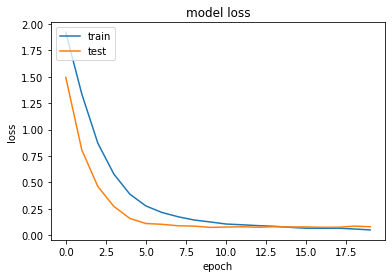

In [0]:
%matplotlib inline
from matplotlib import pyplot
test_acc_bi_lstm = model.evaluate((x_test_Article_pad, x_test_Title_pad, x_test_Author_pad), y_test, verbose=0)
print("Traiing and validation loss")
print('Test loss: %.3f' % (test_acc_bi_lstm[0]))
# plot training history
print("Traiing and validation loss")
pyplot.plot(history.history['loss'], label='train CNN')
pyplot.plot(history.history['val_loss'], label='test CNN')
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

Traiing and validation accuracy
Test accuracy: 0.983


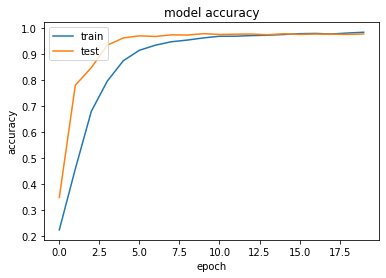

In [0]:

%matplotlib inline
print("Traiing and validation accuracy")
print('Test accuracy: %.3f' % ( test_acc_bi_lstm[1]))
pyplot.plot(history.history['accuracy'], label='train CNN')
pyplot.plot(history.history['val_accuracy'], label='test CNN')
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train','test'], loc='upper left')
pyplot.show()